# Decoder-only Transformer in JAX
Used for NLP and goofing around. The biggest model we trained was 124M Parameters.

Made with brain power of:
- Aksel Joonas Reedi
- Elisa Klunder
- Mihkel Mariusz Jezierski
- Mika Ernesto Umana Lemus

In [68]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import math
import os
from tqdm.auto import tqdm
import tiktoken
import matplotlib.pyplot as plt
import orbax.checkpoint as ocp
from flax.training import orbax_utils
from functools import partial
import numpy as np


key = jax.random.PRNGKey(42)

In [69]:
# Hyperparameters
batch_size = 4
context_length = 1024
train_test_split_size = 0.9
embed_dim = 768
n_heads = 12
mlp_dim_mul = 4  # between 2 and 8 according to UvA
n_blocks = 12
max_iters = 5000
learning_rate = 3e-4


# Generation
temperature = 1

# Checkpoints
delete_checkpoints = True
CHECKPOINT_PATH = "/Users/akseljoonas/Documents/Kool/NN/Final Project/checkpoints"

# Parallelising
devices = jax.local_devices()
print(devices)

# Check if hyperparams make sense
assert embed_dim % n_heads == 0

[CpuDevice(id=0)]


In [70]:
def open_data(folder_path="./dataset"):
    def remove_char(pre_nietzsche_data):
        n_nietzsche_data = pre_nietzsche_data.replace("_", "")
        nietzsche_data = n_nietzsche_data.replace("$", "")
        return nietzsche_data

    full_txt = ""
    for path in os.listdir(folder_path):
        if ".txt" in path:
            txt = open(os.path.join(folder_path, path), "r", encoding="utf-8").read()
            txt = remove_char(txt)
            full_txt += txt
    return full_txt


text = open_data()
len(text)

3396780

In [71]:
class Tokenizer:
    """
    Class that takes care of encoding and decoding the text
    """

    def __init__(self, text: str, tokenizer_type: str = "base") -> None:
        self.tokenizer_type = tokenizer_type

        if self.tokenizer_type == "base":
            self.vocab_size, self.all_characters = self.sort_characters(text)
        elif self.tokenizer_type == "gpt-2":
            self.enc = tiktoken.encoding_for_model("gpt-2")
            self.vocab_size = self.enc.n_vocab

    def get_vocab_size(self):
        return int(jnp.copy(self.vocab_size))

    def sort_characters(self, data):
        all_characters = sorted(list(set(data)))
        vocab_size = len(all_characters)

        return vocab_size, all_characters

    def encode(self, text):
        encoded_text = []
        if self.tokenizer_type == "base":
            for c in text:
                num = self.all_characters.index(c)
                encoded_text.append(num)
        elif self.tokenizer_type == "gpt-2":
            encoded_text = self.enc.encode(text)
        return jnp.array(encoded_text)

    def decode(self, encoded_text):
        text = []
        if self.tokenizer_type == "base":
            for n in encoded_text:
                char = self.all_characters[n]
                text.append(char)
            text = "".join([str(item) for item in text])

        elif self.tokenizer_type == "gpt-2":
            text = self.enc.decode(encoded_text)

        return text

In [72]:
tokenizer = Tokenizer(text=text, tokenizer_type="gpt-2") 
all_data = tokenizer.encode(text)
tokenizer.get_vocab_size()

50257

In [73]:
# test tokenizer
print(tokenizer.decode(all_data[:100]))

What I am now going to relate is the history of the next two centuries.
I shall describe what will happen, what must necessarily happen:
the triumph of Nihilism. This history can be written already; for
necessity itself is at work in bringing it about. This future is
already proclaimed by a hundred different omens; as a destiny it
announces its advent everywhere, for this music of to-morrow all ears
are already pricked.


In [74]:
class BatchLoader:
    def __init__(self, data, train_test_split_size, key) -> None:
        self.training_data, self.validation_data = self.splitting_data(
            data, train_test_split_size
        )
        self.key = key

    def splitting_data(self, data, split_size):
        n = int(split_size * len(data))
        training_data = data[:n]
        validation_data = data[n:]
        return training_data, validation_data

    def get_batch(self, batch_size, context_length, training: bool = True):
        train_batches = []
        target_batches = []

        if training:
            b_data = self.training_data
        else:
            b_data = self.validation_data

        for _ in range(batch_size):
            self.key, subkey = jax.random.split(self.key)
            pos = jax.random.randint(
                key=subkey, shape=(), minval=0, maxval=(len(b_data) - context_length)
            )
            batch_data = b_data[pos : pos + context_length]
            train_batches.append(batch_data)
            batch_data = b_data[pos + 1 : pos + context_length + 1]
            target_batches.append(batch_data)

        train_batches = jnp.stack(train_batches)
        target_batches = jnp.stack(target_batches)

        return train_batches, target_batches

In [75]:
batch_loader = BatchLoader(data=all_data, train_test_split_size=train_test_split_size, key=key)
train, targets = batch_loader.get_batch(batch_size, context_length, training=True)
print(train.shape)
print(targets.shape)

(8, 5)
(8, 5)


In [76]:
class SingleAttentionHead(nn.Module):
    embed_dim: int
    head_size: int

    def setup(self):
        self.key = nn.Dense(self.head_size, use_bias=False) 
        self.query = nn.Dense(self.head_size, use_bias=False)
        self.value = nn.Dense(self.head_size, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training):
        
        k = self.key(data)  # from embed_dim to head_size (B,T,C)
        q = self.query(data) # from embed_size to head_size (B,T,C)
        v = self.value(data) # from embed_size to head_size (B,T,C)

        weights = jnp.matmul(q,jnp.swapaxes(k, -2,-1)) / math.sqrt(self.head_size) # (B,T,T)
        
        #Lower triangular mask matrix of the size B, T, C (same btw as attention)
        mask = jnp.tril(weights)
        
        # for every zero, make it to -inf 
        weights = nn.softmax(jnp.where(mask == 0, -9e16, weights), axis=-1) # axis=-1 since we only want to softmax for each row of T not for the whole data as a whole
        
        weights = self.dropout(weights, deterministic = not training)

        attention = jnp.matmul(weights, v) # (B,T,C)

        return attention

In [77]:
class MultiHeadAttention(nn.Module):
    """
    Multiple attention heads combined together
    """

    head_num: int
    embed_dim: int

    def setup(self):
        self.heads = [
            SingleAttentionHead(
                embed_dim=self.embed_dim, head_size=self.embed_dim // self.head_num
            )
            for _ in range(self.head_num)
        ]
        self.think = nn.Dense(self.embed_dim, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training):
        multiple_attentions = jnp.concatenate(
            [head(data, training) for head in self.heads], axis=-1
        )
        thoughts = self.think(multiple_attentions)
        out = self.dropout(thoughts, deterministic = not training)
        return out

In [78]:
class FeedForward(nn.Module):
    '''Simple Feed Forward NN that goes from embed_dim to a higher dimension and then back to embed_dim'''
    
    embed_dim: int
    dim_mul: int

    def setup(self):
        #this is the heavy thinking part of the model, where it tries to make sense of what was learned
        # in the attention cycle lol
        self.layer1 = nn.Dense(features=(self.dim_mul*self.embed_dim), use_bias=False)
        self.layer2 = nn.Dense(features=self.embed_dim, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training: bool):
        x = data
        x = self.layer1(x)
        x = nn.relu(x)
        x = self.layer2(x)
        x = self.dropout(x, deterministic = not training)
        return x

In [79]:
class Block(nn.Module):
    '''One run through a block, which consists of MultiheadAttention + Feedforward + Layer Normalisation'''
    dim_mul: int
    embed_dim: int
    head_num: int
    
    def setup(self):
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.multihead = MultiHeadAttention(head_num = self.head_num, embed_dim=self.embed_dim)
        self.feedforward = FeedForward(embed_dim=self.embed_dim, dim_mul=self.dim_mul)
    
    def __call__(self, data, training: bool):
        x = data
        x = x + self.multihead(self.norm1(x), training)
        x = x + self.feedforward(self.norm2(x), training)

        return x

In [80]:
class CustomSequential(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x, *args, **kwargs):
        for layer in self.layers:
            x = layer(x, *args, **kwargs)
        return x

In [81]:
class TransformerModel(nn.Module):
    vocab_size: int
    context_length: int
    embed_dim: int
    head_num: int
    dim_mul: int
    n_blocks: int

    def setup(self):
        self.token_embedding_table = nn.Embed(self.vocab_size, self.embed_dim)
        self.position_embedding_table = nn.Embed(self.context_length, self.embed_dim)
        #########################
        self.blocks = CustomSequential(
            [
                Block(
                    head_num=self.head_num,
                    embed_dim=self.embed_dim,
                    dim_mul=self.dim_mul,
                )
                for _ in range(self.n_blocks)
            ]
        )

        #########################
        self.norm = nn.LayerNorm()
        self.linear = nn.Dense(self.vocab_size, use_bias=False)

    def __call__(self, data, training: bool = True):
        _, context_length = data.shape

        token = self.token_embedding_table(data)
        position = self.position_embedding_table(jnp.arange(context_length))

        embedded_data = token + position

        iteration_data = self.blocks(
            embedded_data, training
        )  # data after one iteration MH,FF (4,8,32)
        data_normalized = self.norm(iteration_data)
        final_data = self.linear(data_normalized)

        return final_data

In [82]:
# Optimizer
optimizer = optax.adamw(learning_rate)  # scheduler

In [83]:
# Model init
data = jnp.ones(
    (batch_size, context_length), dtype=jnp.int32
)


model = TransformerModel(
    vocab_size=tokenizer.get_vocab_size(),
    context_length=context_length,
    embed_dim=embed_dim,
    head_num=n_heads,
    dim_mul=mlp_dim_mul,
    n_blocks=n_blocks,
)

# specify what the key is used
key, param_key, dropout_key = jax.random.split(key, num=3)
variables = model.init(param_key, data=data, training=False)

In [84]:
# Training State
params = variables["params"]

orbax_checkpointer = ocp.PyTreeCheckpointer()

dir_path = CHECKPOINT_PATH


class TrainState(train_state.TrainState):
    key: jax.Array


if not os.path.exists(dir_path):
    os.mkdir(dir_path)


if delete_checkpoints:
    path = ocp.test_utils.erase_and_create_empty(dir_path)


if len(os.listdir(dir_path)) > 0:  # If we have saved checkpoints
    print('Getting a saved checkpoint')
    subdirs = sorted((int(d) for d in os.listdir(dir_path)), reverse=True)
    best_model_dir = os.path.join(dir_path, str(subdirs[0]) + "/default/")
    print(f"Loaded state {best_model_dir}")
    empty_state = TrainState.create(
        apply_fn=model.apply,
        params=jax.tree_util.tree_map(np.zeros_like, params),
        key=dropout_key,
        tx=optimizer,
    )
    target = {"model": empty_state}
    state = orbax_checkpointer.restore(best_model_dir, item=target)["model"]
    path = dir_path
else:
    state = TrainState.create(
        apply_fn=model.apply, params=params, key=dropout_key, tx=optimizer
    )
    path = dir_path

In [85]:
# Checkpoints
options = ocp.CheckpointManagerOptions(max_to_keep=3)
checkpoint_manager = ocp.CheckpointManager(path, orbax_checkpointer, options)

In [86]:
@partial(jax.pmap, axis_name="batch")
@jax.jit  # Jit the function for efficiency
def _train_step(state, batch, dropout_key):
    dropout_key, dropout_train_key = jax.random.split(dropout_key)

    def loss_fn(params):
        data, labels = batch

        # Same as model.apply
        logits = state.apply_fn(
            {"params": params}, data, training=True, rngs={"dropout": dropout_train_key}
        )

        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
        mean_loss = jnp.mean(loss)

        return mean_loss, logits

    # Gradient function
    grad_fn = jax.value_and_grad(
        loss_fn,  # Function to calculate the loss
        has_aux=True,  # Function has additional outputs, here accuracy
    )
    # Determine gradients for current model, parameters and batch
    (loss, logits), grads = grad_fn(state.params)

    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss


@partial(jax.pmap, axis_name="batch")
@jax.jit  # Jit the function for efficiency
def _eval_step(state, batch):
    data, labels = batch
    logits = state.apply_fn({"params": state.params}, data, training=False)

    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    mean_loss = jnp.mean(loss)

    return mean_loss


In [87]:
def train(state, num_epochs, dropout_key):
    replicated_state = jax.device_put_replicated(state, jax.local_devices())
    train_losses = []
    eval_losses = []
    best_eval_loss = float("inf")

    for epoch in tqdm(range(num_epochs + 1), miniters=100):
        # Get data
        train, train_labels = batch_loader.get_batch(
            batch_size, context_length, training=True
        )

        # Reshaping to be compatiple with pmap
        dropout_keys = jax.random.split(dropout_key, jax.local_device_count())
        train = train.reshape((jax.local_device_count(), -1, *train.shape[1:]))
        train_labels = train_labels.reshape(
            (jax.local_device_count(), -1, *train_labels.shape[1:])
        )

        # Train step
        train_batch = (train, train_labels)
        replicated_state, gpu_train_losses = _train_step(
            replicated_state, train_batch, dropout_keys
        )

        # Get mean loss across gpus
        train_loss = jnp.mean(gpu_train_losses)

        if epoch % 100 == 0:
            # Get data
            eval, eval_labels = batch_loader.get_batch(
                batch_size, context_length, training=False
            )

            # Reshaping to be compatiple with pmap
            eval = eval.reshape((jax.local_device_count(), -1, *eval.shape[1:]))
            eval_labels = eval_labels.reshape(
                (jax.local_device_count(), -1, *eval_labels.shape[1:])
            )

            # Eval step
            eval_batch = (eval, eval_labels)
            gpu_eval_losses = _eval_step(replicated_state, eval_batch)

            # Get mean loss across gpus
            eval_loss = jnp.mean(gpu_eval_losses)

            # Saving best model according to loss
            if eval_loss < best_eval_loss:
                print(f"Saved model with loss {eval_loss}")
                ckpt = {"model": jax.device_get(replicated_state)}
                save_args = orbax_utils.save_args_from_target(ckpt)

                checkpoint_manager.save(
                    epoch,
                    ckpt,
                    save_kwargs={"save_args": save_args},
                )
                checkpoint_manager.wait_until_finished()
                best_eval_loss = eval_loss

            # Appending losses
            train_losses.append(train_loss)
            eval_losses.append(eval_loss)

            print(f"Epoch {epoch}: Train loss {train_loss}, Eval loss {eval_loss}")

    return jax.device_get(replicated_state), train_losses, eval_losses


def plot_loss_curves(train_losses, eval_losses, eval_interval=100):
    epochs = range(len(train_losses))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, eval_losses, label="Evaluation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Curves")
    plt.legend()
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Saved model with loss 11.321529388427734
Epoch 0: Train loss 11.429646492004395, Eval loss 11.321529388427734


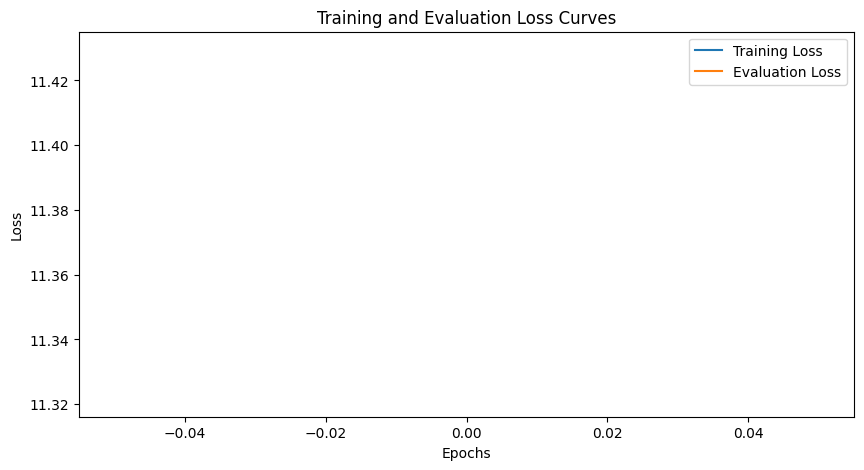

In [88]:
# Training

trained_model_state, train_losses, eval_losses = train(
    state=state, num_epochs=max_iters, dropout_key=dropout_key
)
plot_loss_curves(train_losses, eval_losses)

In [92]:
def generate(state, data, length, temperature):
    params = state.params
    key = jax.random.PRNGKey(42)
    for _ in tqdm(range(length), miniters=length / 10):
        key, subkey = jax.random.split(key)
        generate_keys = jax.random.split(subkey, jax.local_device_count())
        data = _generate_step(state, generate_keys, data, params, temperature)

    return jax.device_get(data[0])


@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(4))
@jax.jit
def _generate_step(state, key, data, params, temperature):
    data_to_use = data[:, -context_length:]

    logits = state.apply_fn({"params": params}, data_to_use, training=False)
    logits = logits[:, -1, :]

    next_token = jax.random.categorical(key, logits / temperature, shape=(1, 1))

    data = jnp.concatenate((data, next_token), axis=1)
    return data


In [96]:
PROMPT = "The meaning of life is "
prompt_tokens = tokenizer.encode(PROMPT)
prompt = jnp.array(prompt_tokens).reshape((1, len(prompt_tokens)))
prompt = jnp.repeat(prompt, jax.device_count(), axis=0).reshape(
    (jax.device_count(), 1, len(prompt_tokens))
)

In [97]:
# Generation

generated_seq = generate(
    trained_model_state,
    prompt,
    50,
    temperature,
)

print(generated_seq)
decoded_text = tokenizer.decode(generated_seq[0])

print(decoded_text)

  0%|          | 0/50 [00:00<?, ?it/s]

[[  464  3616   286  1204   318   220 44779 30610 45551 39654  4546 18246
  10691 25144 33236 10673  1494 25552 14315 21329 28135 19402 39522 20796
  19850  6771 18446 34506  3167 42149 32956 19890 15832 39732 21549   248
  42361 18013   286  8440 38509 27734 23281 48327 10694 34654 40325 45627
  13440 19918 21836  7811 13151 16259 18592  6120]]
The meaning of life is  DRAG768anasia Peshgramfunded dating hersResources © killAGES2005 collectively Guards Laden probabilities scaling Pool Jews mines Ney DisAIR abdomen membr formally runaway Clint� Playoffsagi of shippingBruceLT Frontier assassinateMus printers trimmed rationality analysts bast Anyway principles 125 cycling Sunniagues
